In [ ]:
# Run this only once!!!!!
import functools
import torch

torch.load = functools.partial(torch.load, weights_only=False)


#### NOTE: Run the above cell only once

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.9 ; cuda:  cu126
detectron2: 0.6


In [ ]:
import os
import zipfile
import requests
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, let's train YOLO to detect hands.

In [ ]:
import logging
import os
from collections import OrderedDict
from tqdm import tqdm
import torch
import cv2
import random

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.evaluation import (
    DatasetEvaluators,
    PascalVOCDetectionEvaluator,
    verify_results,
)
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.pascal_voc import register_pascal_voc


In [ ]:
def hand_detection(
        img_path: str,
        model_path: str,
        config_path: str,
        glove_threshold: float = 0.8
        ):

    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

    os.makedirs('./viz', exist_ok=True)

    predictor = DefaultPredictor(cfg)

    im = cv2.imread(img_path)
    if im is None:
        print(f"Error: Could not load image at '{img_path}'")
        return

    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")

    # Get scores
    scores = instances.scores.numpy()
    boxes = instances.pred_boxes

    # Create custom labels based on threshold
    labels = []
    for score in scores:
        labels.append(f"Hand {score*100:.1f}%")
        # if score >= glove_threshold:
        #     labels.append(f"Glove {score*100:.1f}%")
        # else:
        #     labels.append(f"Hand {score*100:.1f}%")

    # Draw with custom labels
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

    # Use draw_instance_predictions with custom labels
    v = v.overlay_instances(
        boxes=boxes,
        labels=labels,
    )

    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(v.get_image())
    plt.axis('off')
    plt.title(f"Detected: {len(instances)} hands")
    plt.show()

    # Print detections
    for i, (score, box) in enumerate(zip(scores, boxes)):
        label = "Hand"
        # label = "Glove" if score >= glove_threshold else "Hand"
        print(f"{label}: {score*100:.1f}% - Box: {box}")

    # Save
    cv2.imwrite(f'./viz/output_{image_path.split("/")[-1]}', v.get_image()[:, :, ::-1])

In [ ]:
# Model Paths
hand_model_path = "/content/drive/MyDrive/ComputerVision/hand_model.pth"
# image_path = "/content/drive/MyDrive/ComputerVision/Test_image.jpeg"
image_path = "/content/drive/MyDrive/ComputerVision/test-img.jpg"

# Configuration
yaml_path = "/content/drive/MyDrive/ComputerVision/faster_test.yaml"

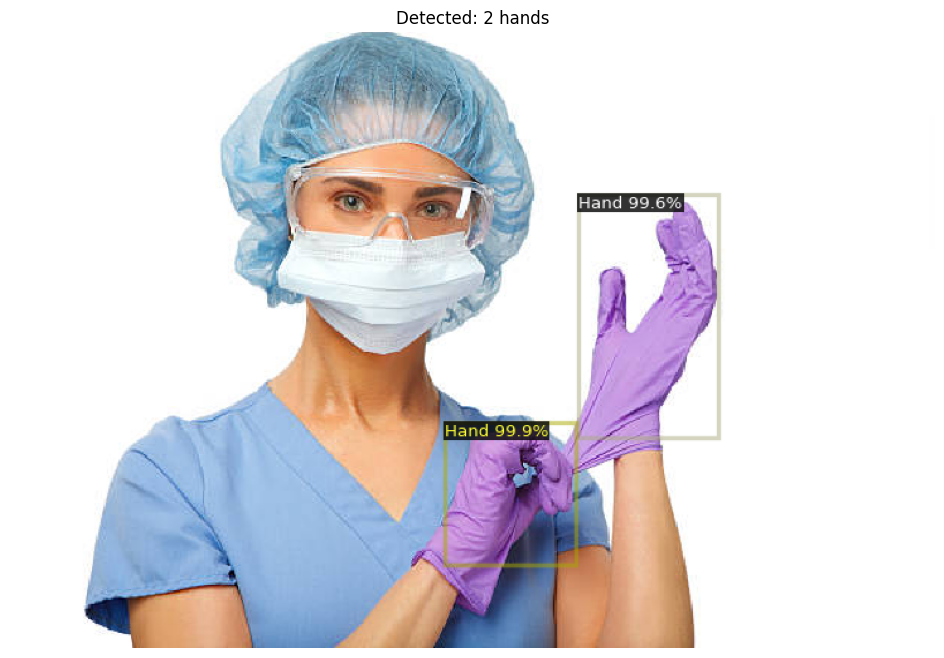

Hand: 99.9% - Box: tensor([287.5930, 259.0489, 373.8036, 352.7264])
Hand: 99.6% - Box: tensor([376.1449, 108.1968, 468.4377, 268.6123])


In [ ]:
hand_detection(
    image_path,
    hand_model_path,
    yaml_path,
    )